In [1]:
!git clone https://github.com/bearpelican/musicautobot.git

fatal: destination path 'musicautobot' already exists and is not an empty directory.


In [2]:
import os
os.chdir('musicautobot')

In [3]:
!apt install musescore fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
musescore is already the newest version (2.1.0+dfsg3-3build1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [4]:
!pip install torch fastai music21 pebble fluidsynth midi2audio

In [5]:
!pip install musicautobot

In [6]:
from musicautobot.numpy_encode import *
from musicautobot.utils.file_processing import process_all, process_file
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.utils.setup_musescore import setup_musescore
setup_musescore()

In [7]:
from midi2audio import FluidSynth
from IPython.display import Audio

In [8]:
#convert .midi to .wav
def play_wav(stream):
    out_midi = stream.write('midi')
    out_wav = str(Path(out_midi).with_suffix('.wav'))
    FluidSynth("font.sf2").midi_to_audio(out_midi, out_wav)
    return Audio(out_wav)

In [9]:
midi_path =  Path('/content/drive/MyDrive/data/midi/examples/Bach')
data_path = Path('/content/drive/MyDrive/data/numpy')

In [10]:
# For empty data
#data = MusicDataBunch.empty(data_path)
# For Saved Data:
data = load_data(data_path, 'musicitem_data_save.pkl')
vocab = data.vocab

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Download pretrained model
pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformerKeyC.pth'
# another pretrained model: pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformer.pth'
pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
pretrained_path.parent.mkdir(parents=True, exist_ok=True)
download_url(pretrained_url, dest=pretrained_path)

In [13]:
learn = music_model_learner(data, pretrained_path=pretrained_path)

In [14]:
midi_files = get_files(midi_path, recurse=True, extensions='.midi'); midi_files[:126]

[PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/bach_art_of_fugue_1080_1_(c)harfesoft.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/bach_art_of_fugue_1080_2_(c)harfesoft.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_11_(c)maclean.midi'),
 PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_10_(c)maclean.midi')]

In [15]:
idx = 3
f = midi_files[idx]; f

PosixPath('/content/drive/MyDrive/data/midi/examples/Bach/kunst_der_fuge_10_(c)maclean.midi')

In [16]:
cutoff_beat = 100

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

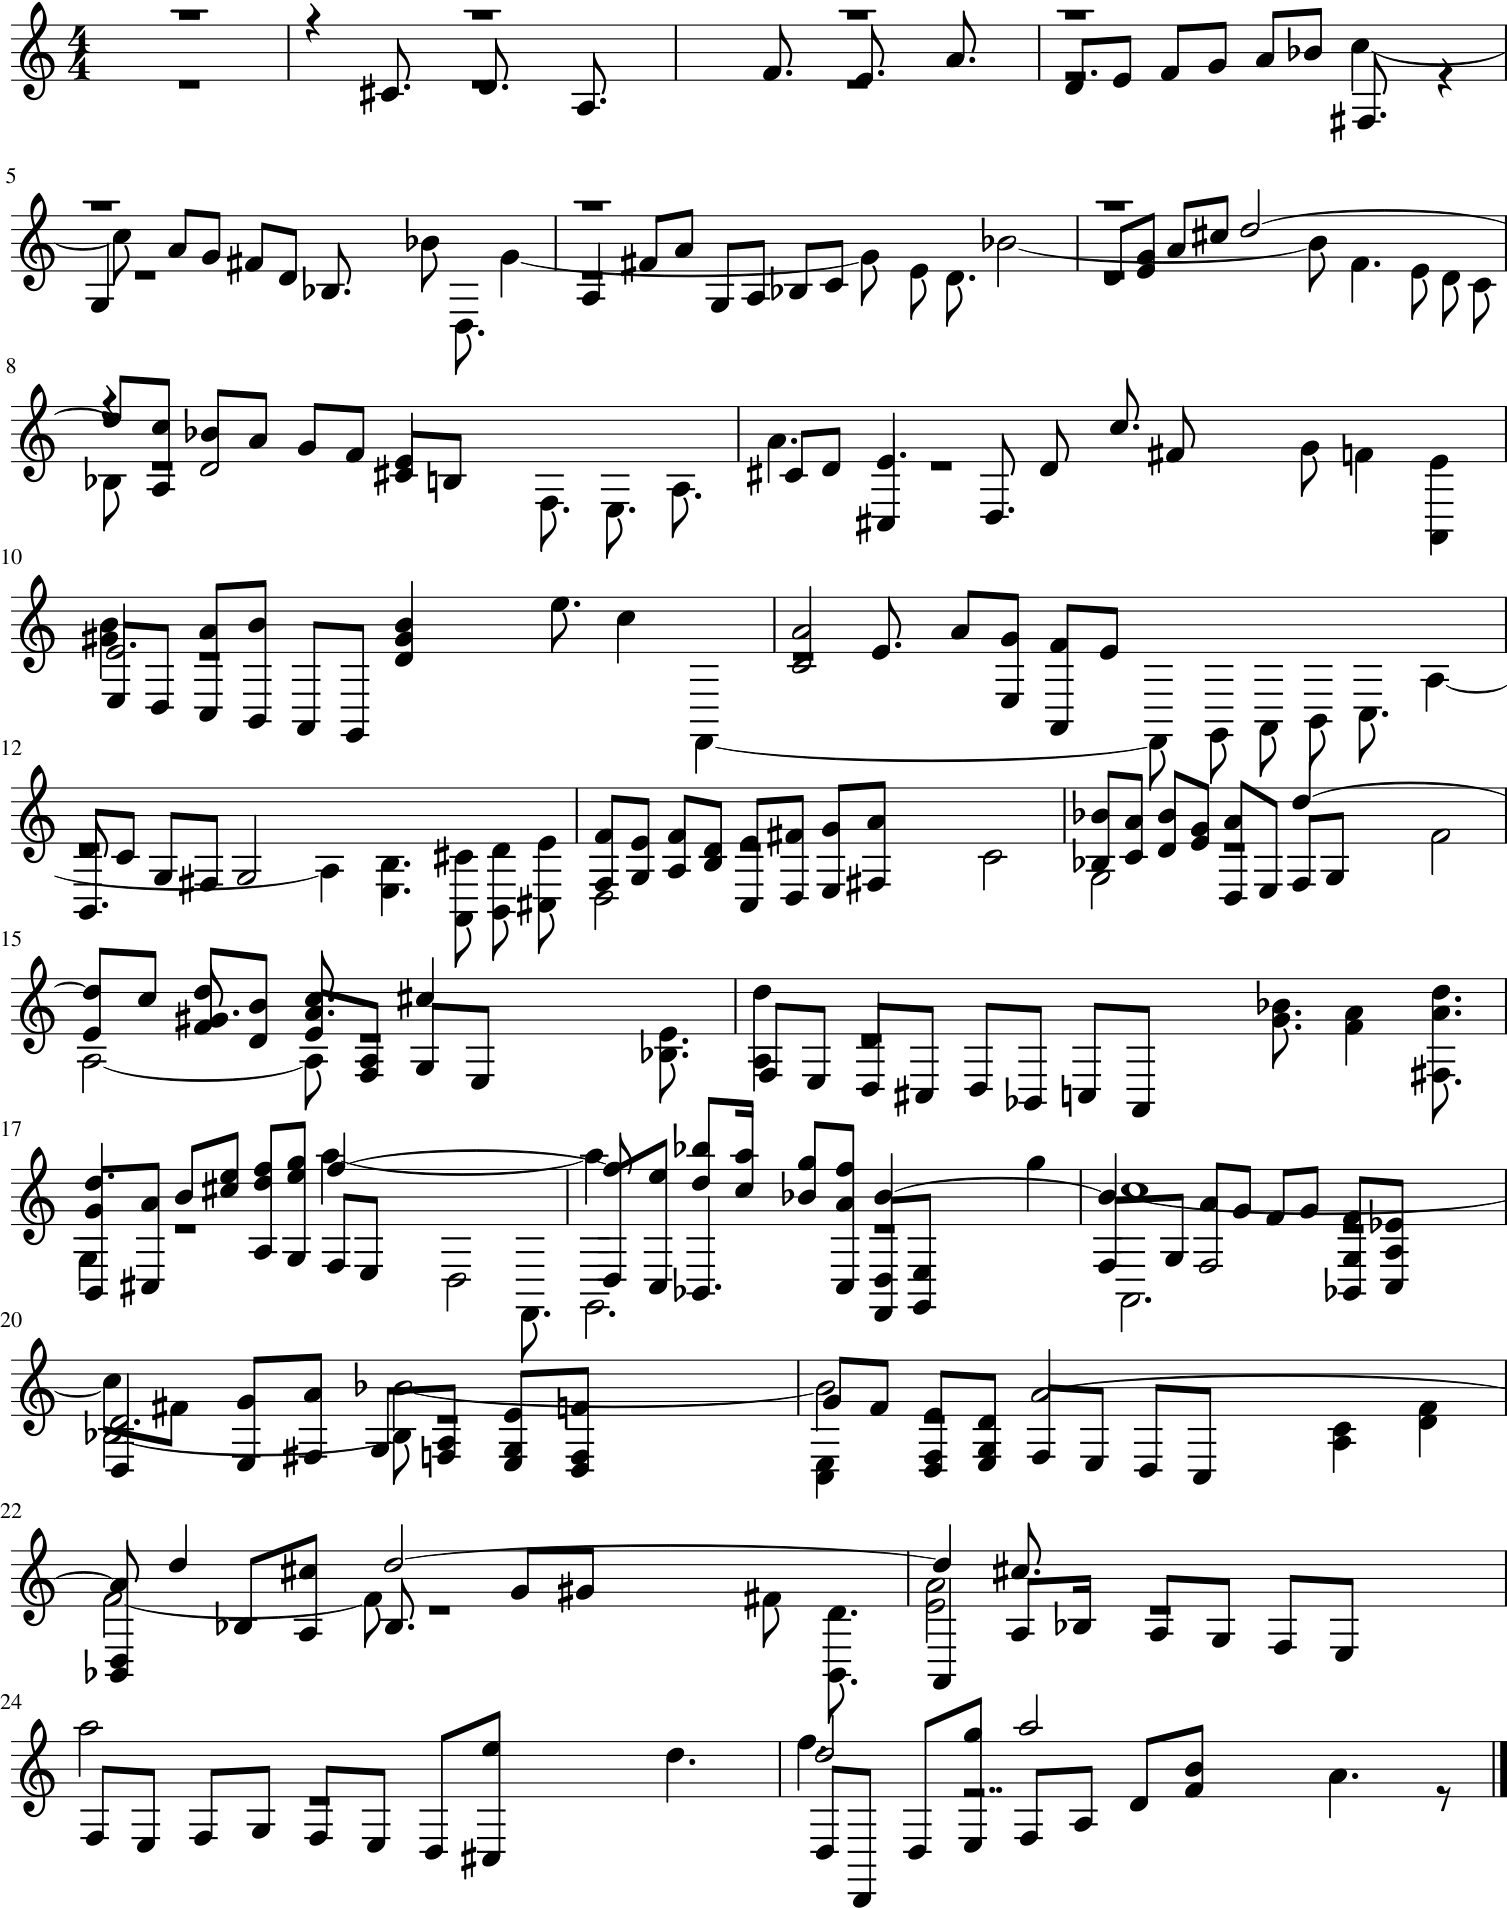

In [17]:
seed_item.show()

In [18]:
play_wav(seed_item.stream)

Output hidden; open in https://colab.research.google.com to view.

In [19]:
pred, full = learn.predict(seed_item, n_words=500, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

/content/musicautobot/musicautobot/music_transformer/model.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bar_pos = pos // self.beat_len % self.max_bar_len
/content/musicautobot/musicautobot/music_transformer/learner.py:120: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if ((last_pos - start_pos) // 16) <= min_bars: logits[vocab

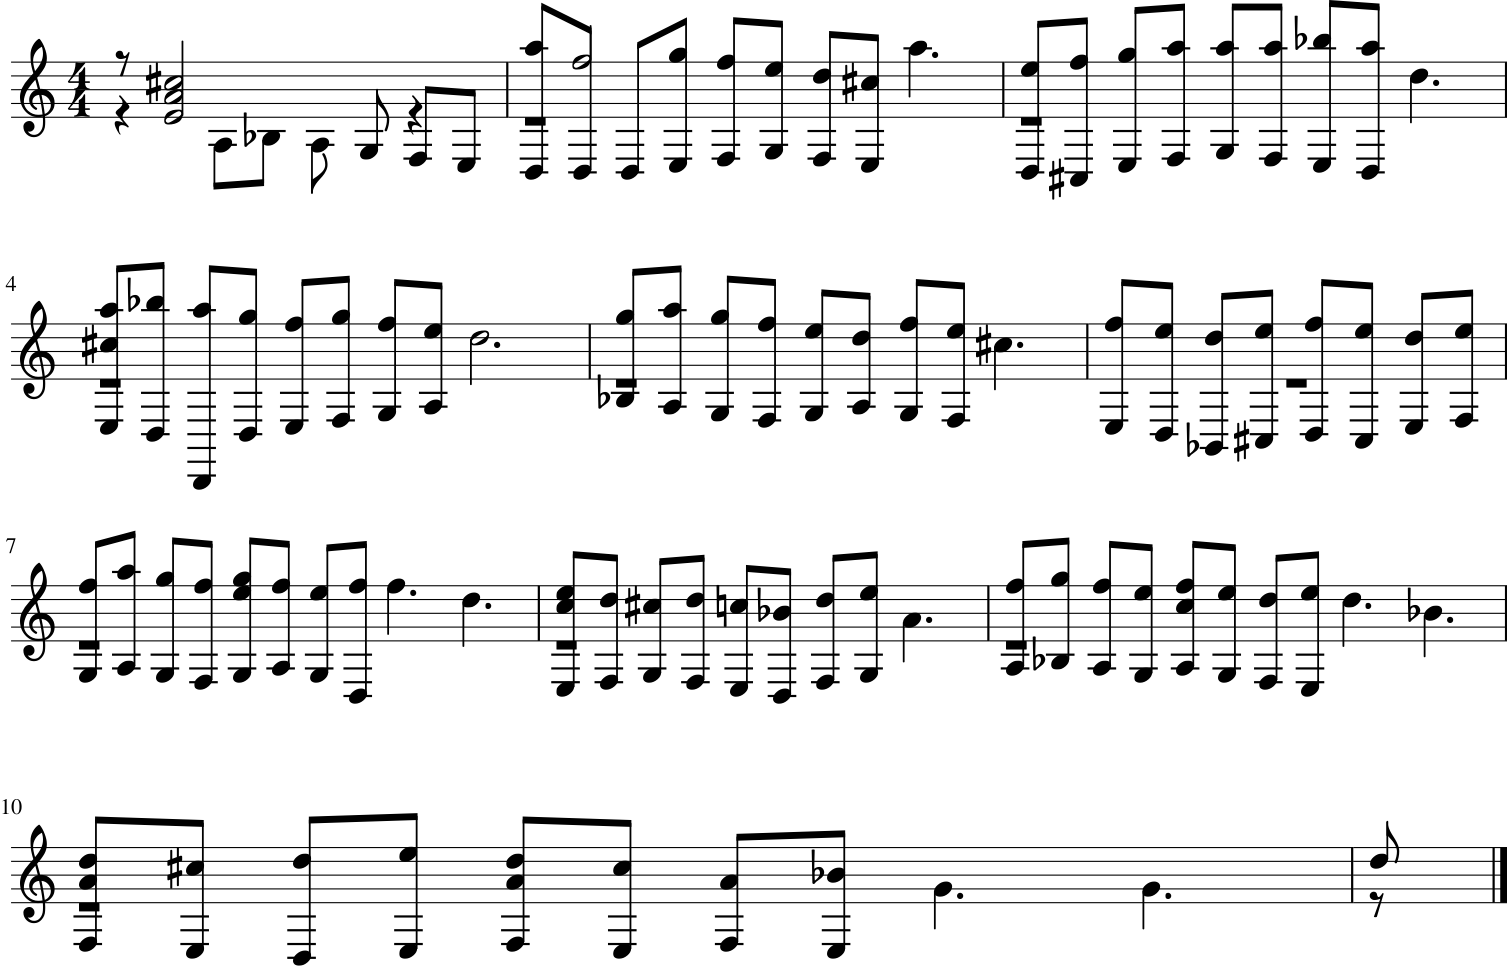

In [20]:
pred.show()

In [21]:
play_wav(pred.stream)

Output hidden; open in https://colab.research.google.com to view.

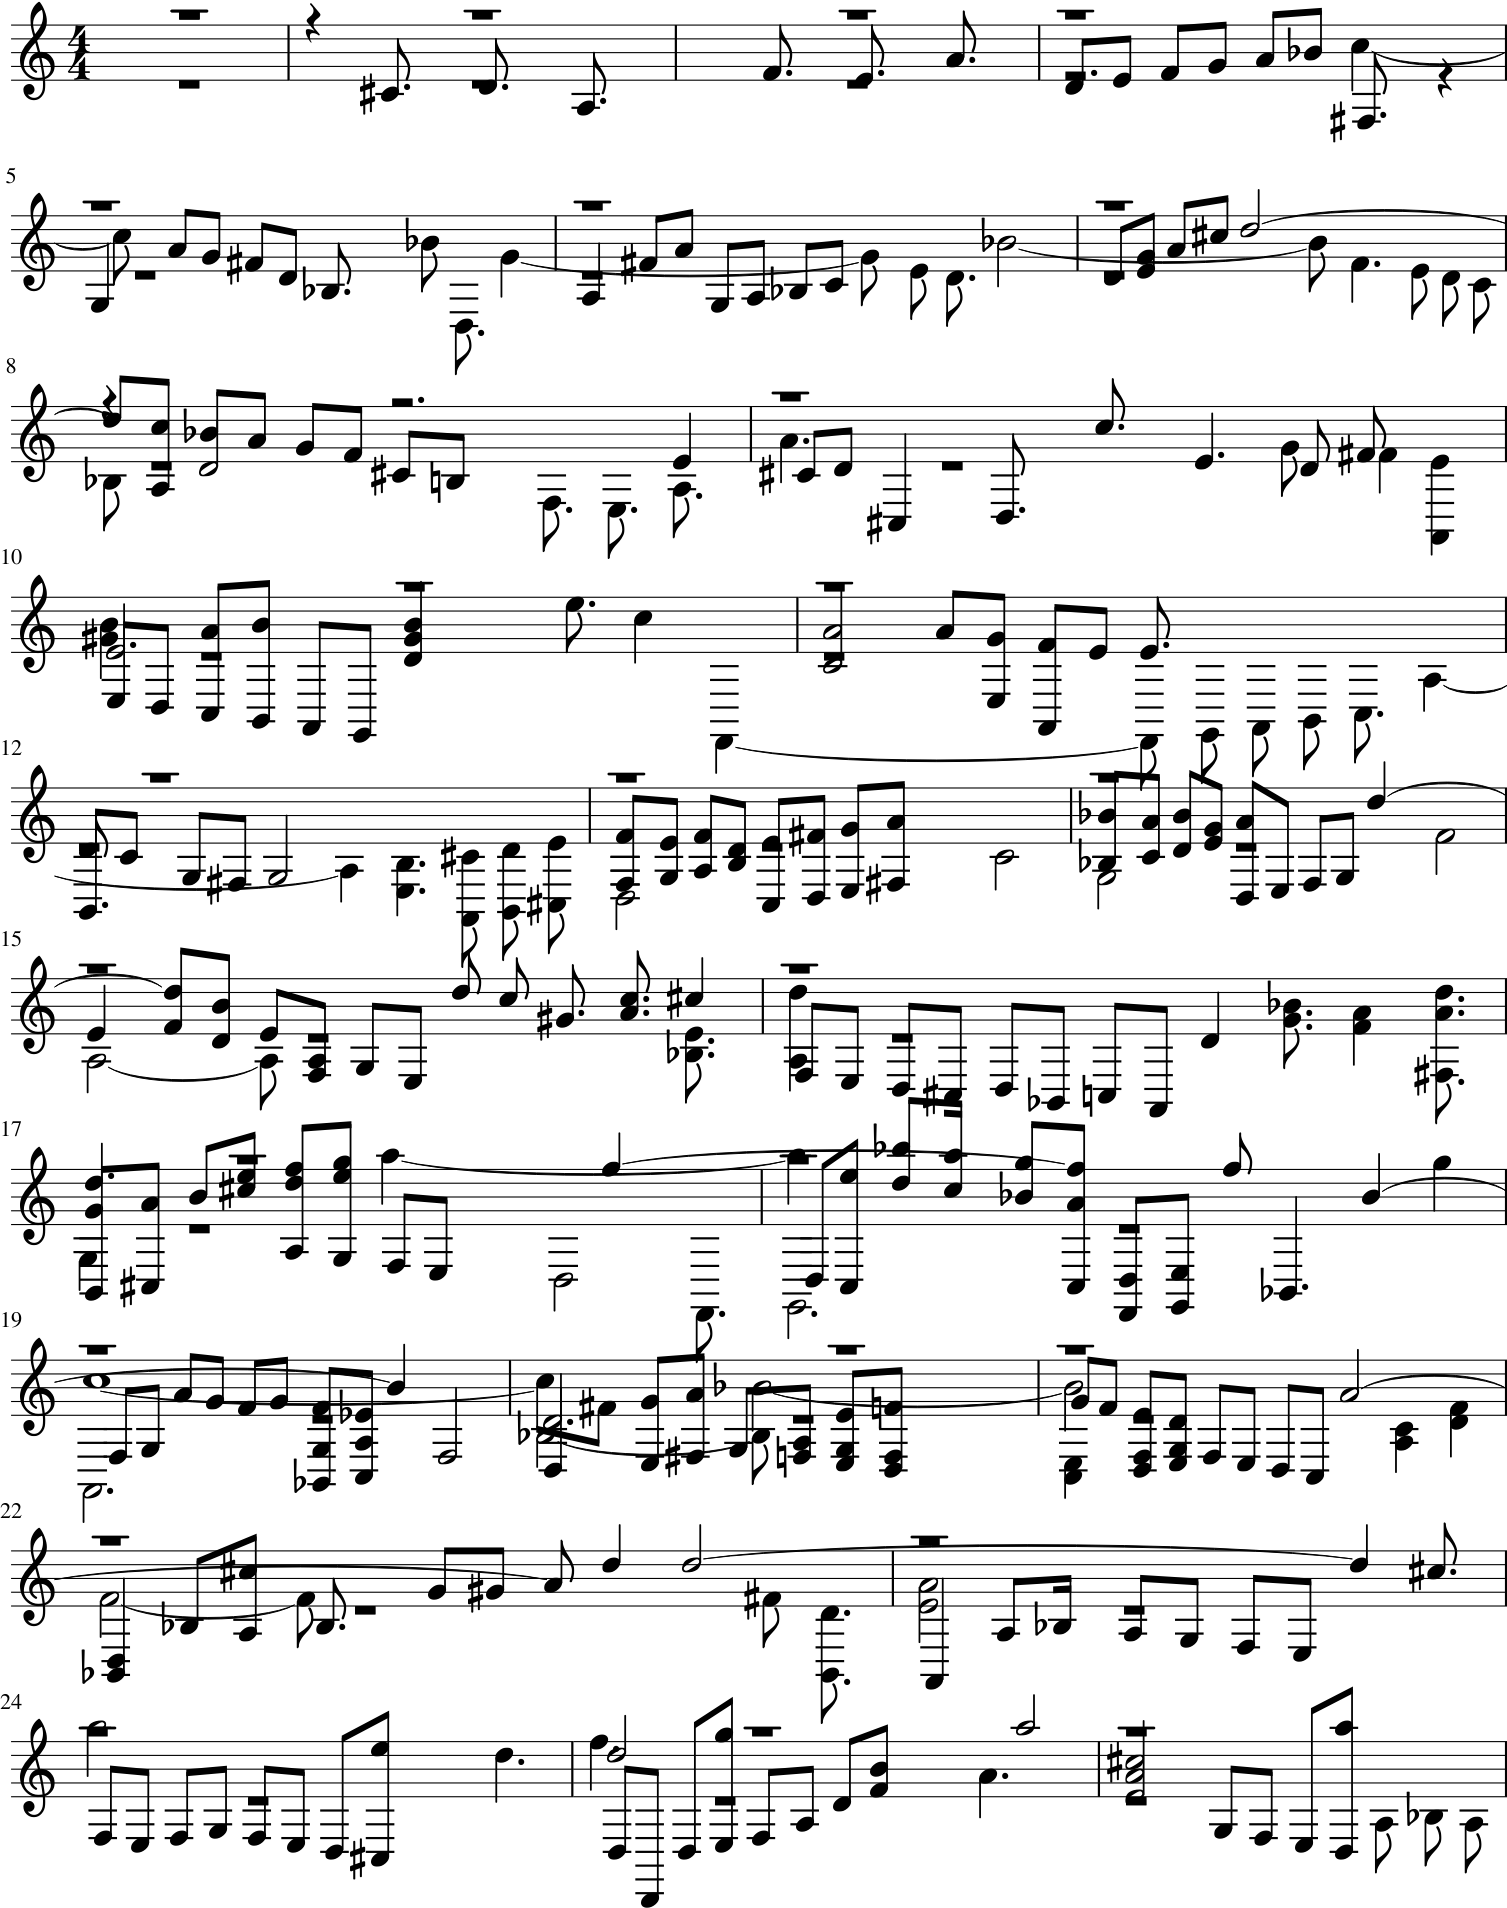

In [22]:
full_song = seed_item.append(pred); full_song.show()

In [23]:
play_wav(full_song.stream)

Output hidden; open in https://colab.research.google.com to view.

Add random noise

In [24]:
note_temp = 1.4 # Determines variation
dur_temp = 0.8 # Determines randomness
top_k = 30
pred, full = learn.predict(seed_item, n_words=500, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

/content/musicautobot/musicautobot/music_transformer/model.py:63: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bar_pos = pos // self.beat_len % self.max_bar_len
/content/musicautobot/musicautobot/music_transformer/learner.py:120: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if ((last_pos - start_pos) // 16) <= min_bars: logits[vocab

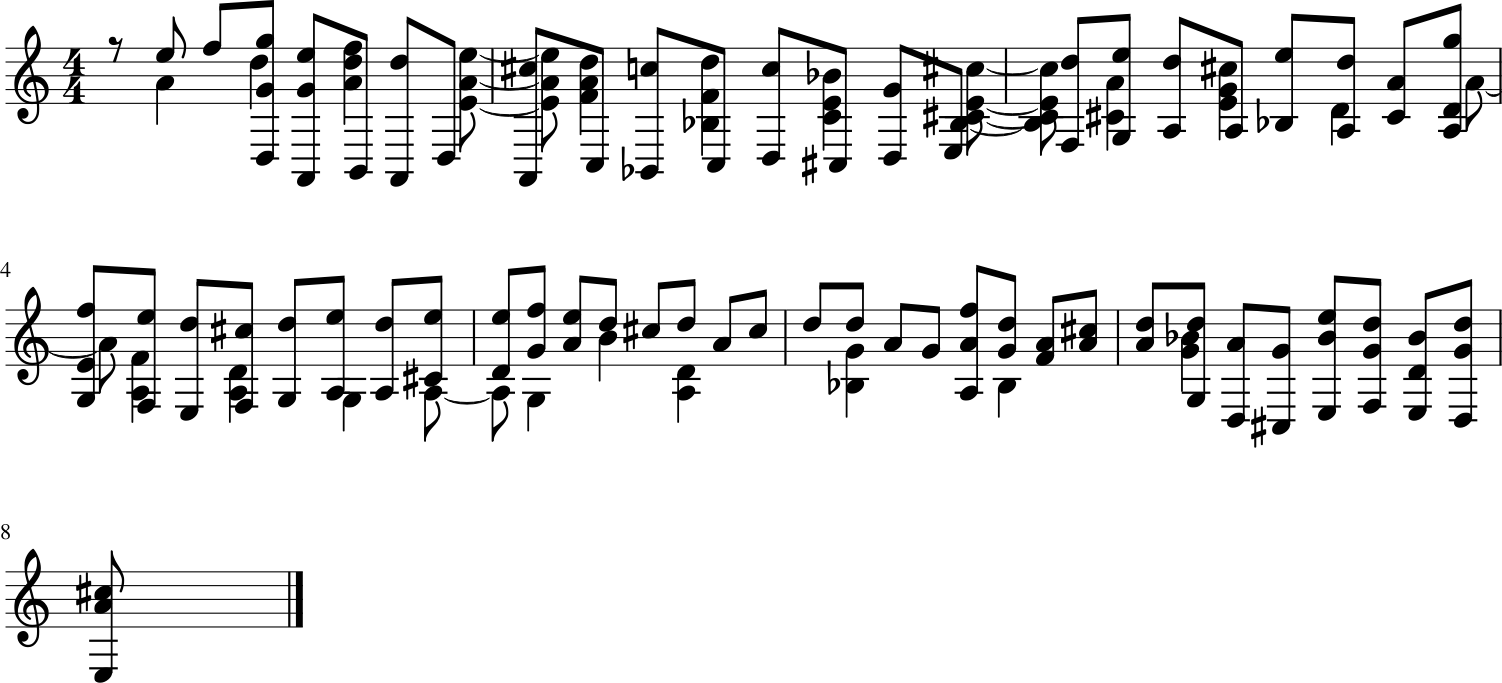

In [25]:
pred.show()

In [26]:
play_wav(pred.stream)

Output hidden; open in https://colab.research.google.com to view.